<a href="https://colab.research.google.com/github/g0pher98/pytorch-study/blob/main/chap5_artificial_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1. 다층 퍼셉트론

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
'''
5.1.1. 선형회귀
'''
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.rand(5,1)

x, y

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.]]), tensor([[3.9322e-03],
         [2.7758e+00],
         [4.9623e+00],
         [6.9432e+00],
         [8.3287e+00]]))

In [3]:
class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(1, 1, bias = True) # y = wx + b
  
  def forward(self, x):
    y = self.fc(x)

    return y

In [4]:
model = LinearRegressor()
learning_rate = 1e-3
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
loss_stack = []
for epoch in range(1001):
  optimizer.zero_grad()

  y_hat = model(x)
  loss = loss_func(y_hat, y)

  loss.backward()
  optimizer.step()
  loss_stack.append(loss.item())

  if epoch % 100 == 0:
    print(f'Epoch {epoch}: Loss({loss.item()}) ')

Epoch 0: Loss(13.331106185913086) 
Epoch 100: Loss(1.0271213054656982) 
Epoch 200: Loss(0.19803236424922943) 
Epoch 300: Loss(0.14121493697166443) 
Epoch 400: Loss(0.1364789456129074) 
Epoch 500: Loss(0.13535018265247345) 
Epoch 600: Loss(0.13455551862716675) 
Epoch 700: Loss(0.1338638812303543) 
Epoch 800: Loss(0.13325130939483643) 
Epoch 900: Loss(0.13270774483680725) 
Epoch 1000: Loss(0.1322251707315445) 


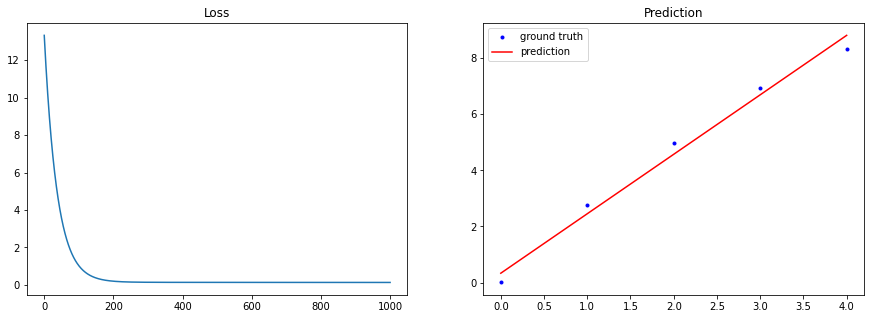

In [6]:
with torch.no_grad(): # 예측은 학습이 아니기 때문
  y_hat = model(x)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")

plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")

plt.show()

In [7]:
'''
5.1.2. 집값 예측하기

  - 선형 회귀식(nn.Linear())은 비선형 관계를 해석하기 어려움.
  - 선형 회귀식을 여러 층으로 구성한 "다층 신경망(Multi-layer Perceptron:MLP)"
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

회귀 문제(Regression)에서 모델 평가를 위해 RMSE(Root Mean Squared Error, MSE의 제곱근)를 사용한다.

$MSE = \frac{1}{N} \sum \limits _{i=1}^N (y_i-\hat y_i)^2$

기존의 MSE는 음수로 인해 기본 결과값에 제곱을 하는 과정을 취하는데, 여기서 원본 값과의 차이가 발생한다. 따라서, 동일한 단위로 맞추기 위해 제곱근을 취하는 RMSE로 오차를 평가한다.

$RMSE = \sqrt{ \frac{1}{N} \sum \limits _{i=1}^N (y_i-\hat{y_i})^2}$




In [8]:
from sklearn.datasets import load_boston

boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [9]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['Price'] = boston.target
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [10]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1, 1))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [12]:
class BostonTensorData(Dataset):

  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]
  
  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.len

In [13]:
trainsets = BostonTensorData(X_train, Y_train)
testsets  = BostonTensorData(X_test,  Y_test)

In [14]:
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)
testloader  = torch.utils.data.DataLoader(testsets,  batch_size=32, shuffle=True)

In [28]:
class Regressor(nn.Module):
  '''
  모델 만들기
  
  input layer(13) -> hidden layer(50) -> hidden layer(30) -> output layer(1)
  '''

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True) # input(13) -> hidden(50)
    self.fc2 = nn.Linear(50, 30, bias=True) # hidden(50) -> hidden(30)
    self.fc3 = nn.Linear(30, 1, bias=True) # hidden(30) -> output(1)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))
    return x

In [29]:
model = Regressor()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [30]:
# 학습하기

loss_ = []
n = len(trainloader)
for epoch in range(600):
  running_loss = 0.0
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, values)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() # 매 턴 loss 더함.
  
  if epoch % 50 == 0:
    print(f"Epoch {epoch} loss : {running_loss/n}")

  loss_.append(running_loss/n) # 1epoch 간 loss 평균치 저장

Epoch 0 loss : 560.3319435119629
Epoch 50 loss : 99.40283203125
Epoch 100 loss : 88.93790674209595
Epoch 150 loss : 85.19441938400269
Epoch 200 loss : 69.76519632339478
Epoch 250 loss : 63.08151388168335
Epoch 300 loss : 64.50308179855347
Epoch 350 loss : 67.03557085990906
Epoch 400 loss : 47.58235549926758
Epoch 450 loss : 66.89267063140869
Epoch 500 loss : 46.145854234695435
Epoch 550 loss : 53.636147022247314


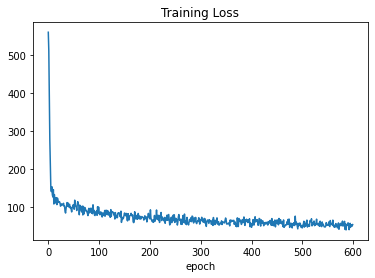

In [31]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
# 모델 평가하기

def evaluation(dataloader):

  pred   = torch.tensor([], dtype=torch.float) # 예측값
  actual = torch.tensor([], dtype=torch.float) # 실제값

  with torch.no_grad():
    model.eval() # dropout과 같은 정규화 기법 비활성화(train에서만 동작해야함)
    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)
      pred   = torch.cat((pred,  outputs), 0) # ???? 여기 잘 이해가 안됨 ???????
      actual = torch.cat((actual, values), 0)
    
  pred   = pred.numpy()
  actual = actual.numpy()
  rmse = np.sqrt(mean_squared_error(pred, actual)) # MSE에 루트를 씌워 RMSE 산출

  return rmse
 